In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import losses, layers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import Sequential

In [2]:
df=pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data=df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
labels=raw_data[:,-1]
data=raw_data[:, 0:-1]

In [4]:
train_data, test_data, train_labels, test_labels=train_test_split(data, labels, test_size=0.2, random_state=21)

In [5]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)

train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)

train_data=tf.cast(train_data, tf.float32)
test_data=tf.cast(test_data, tf.float32)

In [15]:
train_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data=train_data[train_labels]
normal_test_data=test_data[test_labels]

anomalous_train_data=train_data[~train_labels]
anomalous_test_data=test_data[~test_labels]

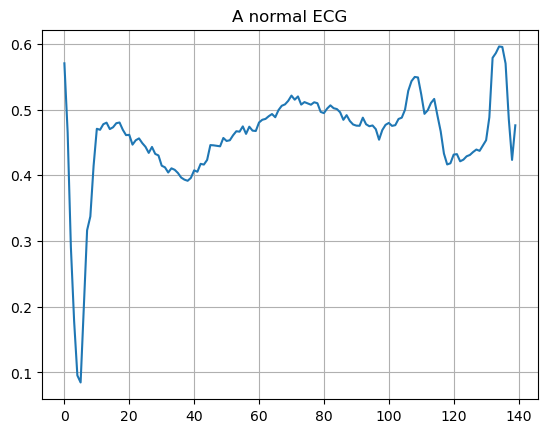

In [16]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A normal ECG")
plt.show()

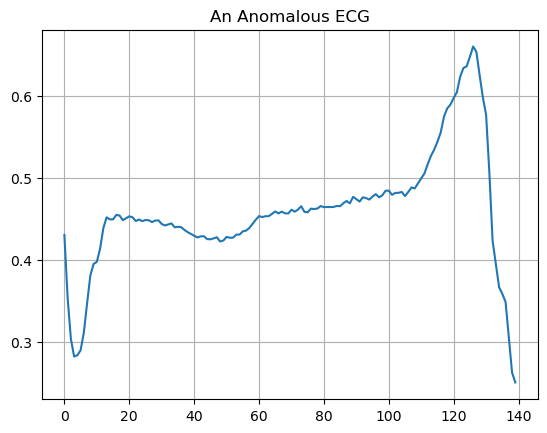

In [17]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [19]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder=tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])
        self.decoder=tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])
    def call(self, x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded
autoencoder=AnomalyDetector()

In [20]:
autoencoder.compile(optimizer='adam', loss='mae')

In [21]:
history=autoencoder.fit(normal_train_data, normal_train_data, 
                        epochs=20, 
                        batch_size=521, 
                        validation_data=(test_data, test_data),
                        shuffle=True)

Epoch 1/20
5/5 [==============================] - 2s 62ms/step - loss: 0.0626 - val_loss: 0.0546
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0556 - val_loss: 0.0520
Epoch 3/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0525 - val_loss: 0.0505
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0490 - val_loss: 0.0483
Epoch 5/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0450 - val_loss: 0.0465
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0411 - val_loss: 0.0444
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0378 - val_loss: 0.0429
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0350 - val_loss: 0.0416
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0326 - val_loss: 0.0403
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0304 - val_loss: 0.0392
Epoch 11/20
5/5 [============

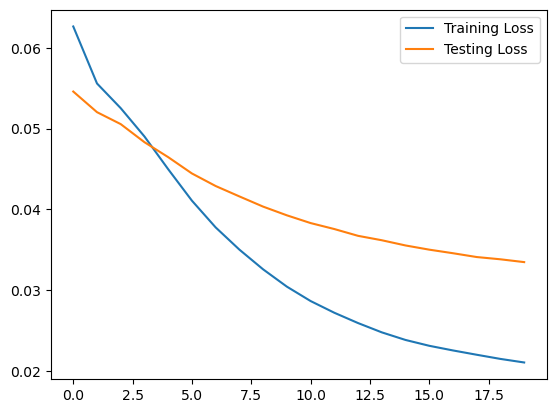

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Testing Loss")
plt.legend()

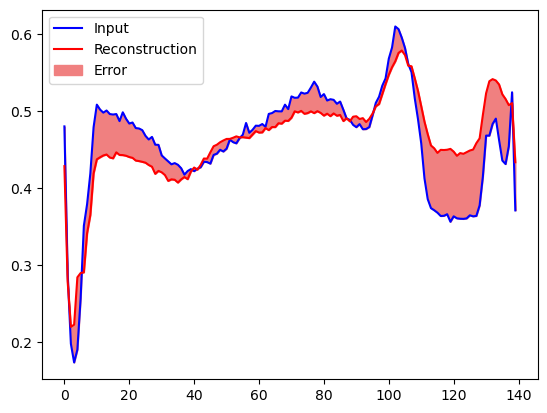

In [24]:
encoded_imgs=autoencoder.encoder(normal_test_data).numpy()
decoded_imgs=autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_imgs[0], 'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

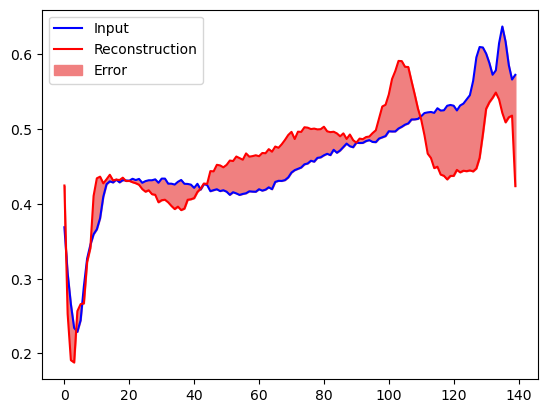

In [29]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

74/74 [==============================] - 0s 1ms/step


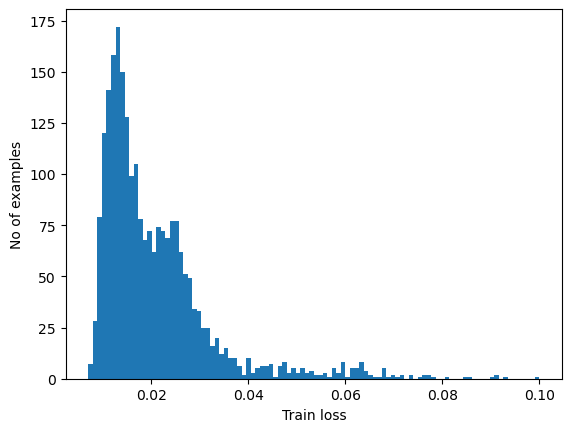

In [30]:
reconstructions=autoencoder.predict(normal_train_data)
train_loss=tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None, :], bins=100)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [31]:
threshold=np.mean(train_loss)+np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0326836


14/14 [==============================] - 0s 1ms/step


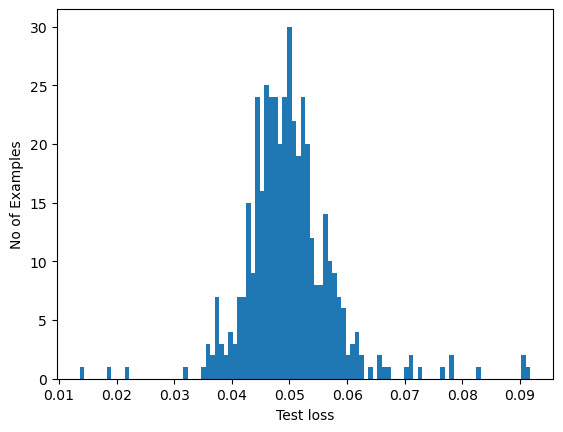

In [33]:
reconstructions=autoencoder.predict(anomalous_test_data)
test_loss=tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=100)
plt.xlabel("Test loss")
plt.ylabel("No of Examples")
plt.show()

In [36]:
def predict(model, data, threshold):
    reconstructions=model(data)
    loss=tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy={}".format(accuracy_score(labels, preds)))
    print("Precision={}".format(precision_score(labels, preds)))
    print("Recall={}".format(recall_score(labels, preds)))

In [37]:
preds=predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy=0.943
Precision=0.9921722113502935
Recall=0.9053571428571429
